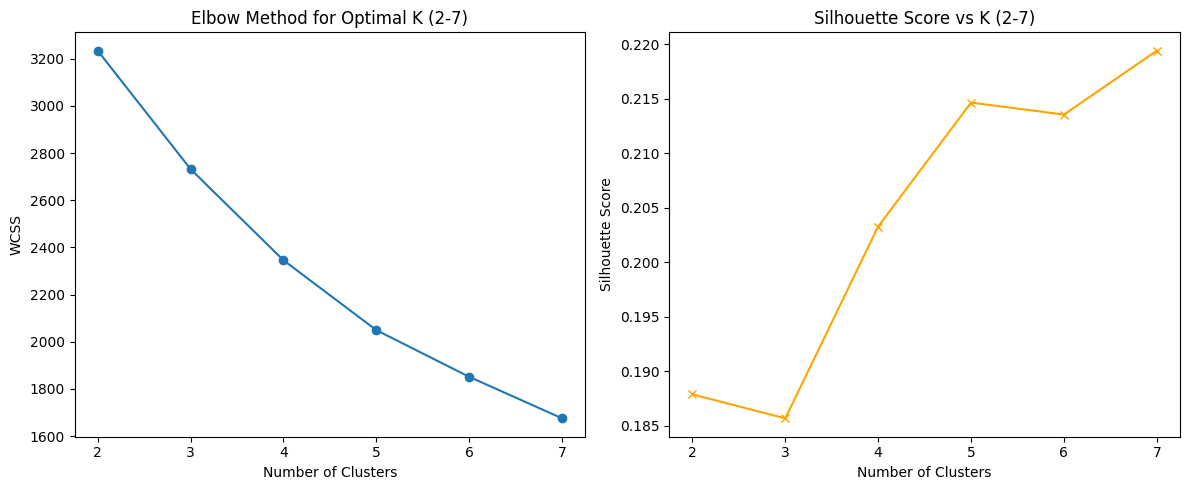

Optimal number of clusters (by silhouette score): 7


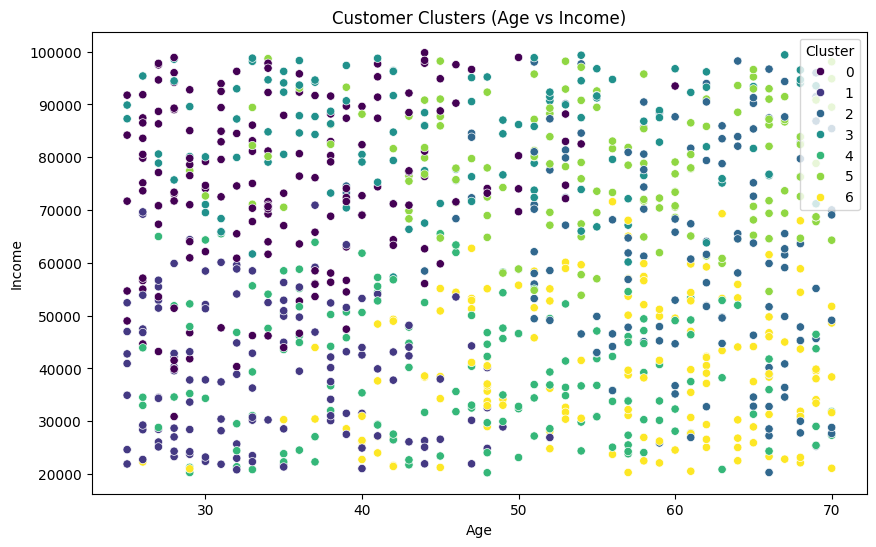

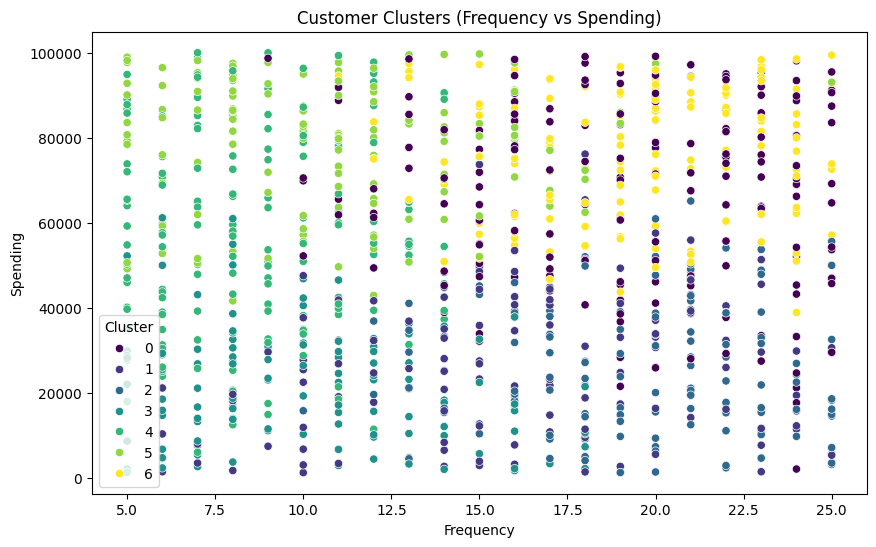

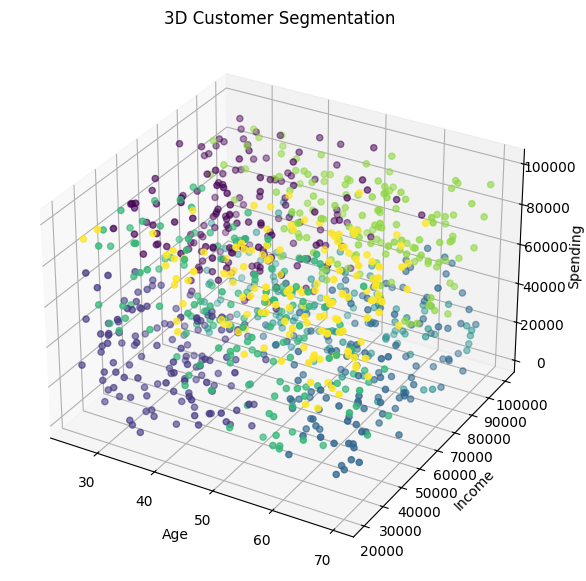


Cluster Summary (mean values):
           age    income  frequency  spending
cluster                                      
0        35.39  74829.63      19.17  66466.91
1        34.25  39224.45      16.41  25767.59
2        60.58  61971.41      19.61  26523.69
3        45.81  84352.85      10.23  22159.08
4        47.18  39569.92       8.66  56504.62
5        55.02  78245.66      10.78  77865.86
6        55.89  40168.29      19.36  75808.20

Cluster Sizes:
cluster
0    170
1    130
2    136
3    118
4    155
5    144
6    147
Name: count, dtype: int64

Customer Segment Profiles:
Cluster 0: High-income, high-spending (Premium Customers)
age             35.39
income       74829.63
frequency       19.17
spending     66466.91
Name: 0, dtype: float64
----------------------------------------
Cluster 1: Young, frequent shoppers (Enthusiasts)
age             34.25
income       39224.45
frequency       16.41
spending     25767.59
Name: 1, dtype: float64
----------------------------------------

KNeighborsClassifier(n_neighbors=3)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

import os

# Load dataset or create synthetic data if file does not exist
if not os.path.exists('C:/Users/HP/Python/Data Science Projects/customer_data.csv'):
    np.random.seed(42)
    n_samples = 200
    df = pd.DataFrame({  # for emergency when dataset is not available
        'age': np.random.randint(18, 70, size=n_samples),
        'income': np.random.randint(20000, 120000, size=n_samples),
        'frequency': np.random.randint(1, 30, size=n_samples),
        'spending': np.random.randint(100, 10000, size=n_samples)
    })
    df.to_csv('customer_data.csv', index=False)
else:
    df = pd.read_csv('customer_data.csv')

# Clean column names and ensure all are lowercase, no spaces
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# Check for missing values and fill if necessary
if df.isnull().sum().sum() > 0:
    df = df.fillna(df.median(numeric_only=True))

# Selecting relevant features (only those mentioned in requirements)
feature_cols = ['age', 'income', 'frequency', 'spending']
df = df[feature_cols]  # Keep only required columns

features = df[feature_cols]

# Scaling data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Finding the optimal number of clusters (Elbow Method + Silhouette)
wcss = []
silhouette_scores = []
K_range = range(2, 8)  
for i in K_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(K_range), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K (2-7)')

plt.subplot(1, 2, 2)
plt.plot(list(K_range), silhouette_scores, marker='x', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K (2-7)')
plt.tight_layout()
plt.show()

# Choose optimal clusters based on silhouette score (3–5 meaningful clusters)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (by silhouette score): {optimal_k}")

# Fit KMeans with optimal_k and assign cluster labels
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

# 2D Scatter Plot: Age vs Income
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['age'], y=df['income'], hue=df['cluster'], palette='viridis')
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Customer Clusters (Age vs Income)')
plt.legend(title='Cluster')
plt.show()

# 2D Scatter Plot: Frequency vs Spending
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['frequency'], y=df['spending'], hue=df['cluster'], palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Spending')
plt.title('Customer Clusters (Frequency vs Spending)')
plt.legend(title='Cluster')
plt.show()

# 3D Scatter Plot: Age, Income, Spending
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age'], df['income'], df['spending'], c=df['cluster'], cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Spending')
ax.set_title('3D Customer Segmentation')
plt.show()

# Printing cluster summary for marketing insights
print("\nCluster Summary (mean values):")
summary = df.groupby('cluster')[feature_cols].mean().round(2)
print(summary)

# Print cluster sizes
print("\nCluster Sizes:")
print(df['cluster'].value_counts().sort_index())

# Identifying 5 meaningful customer types for marketing
print("\nCustomer Segment Profiles:")
for cluster_id, row in summary.iterrows():
    desc = []
    if row['income'] > summary['income'].mean() and row['spending'] > summary['spending'].mean():
        desc.append("High-income, high-spending (Premium Customers)")
    elif row['age'] < summary['age'].mean() and row['frequency'] > summary['frequency'].mean():
        desc.append("Young, frequent shoppers (Enthusiasts)")
    elif row['spending'] < summary['spending'].mean() and row['frequency'] < summary['frequency'].mean():
        desc.append("Low-spending, infrequent (Budget/Occasional Shoppers)")
    elif row['age'] > summary['age'].mean():
        desc.append("Older customers (Mature Segment)")
    else:
        desc.append("Average/Regular Customers")
    print(f"Cluster {cluster_id}: {', '.join(desc)}")
    print(row)
    print("-" * 40)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(scaled_features, df['cluster'])

# KMeans is used to find groups (clusters) of similar customers.
# KNN is not used to make clusters, but it can help us assign a new customer to the nearest cluster.

# Example: If a new customer comes in, we can use KNN to predict which cluster they belong to.
# Uncomment and change the values below to test with your own customer data:
# new_customer = np.array([[35, 60000, 10, 3000]])  # age, income, frequency, spending
# new_customer_scaled = scaler.transform(new_customer)
# predicted_cluster = knn.predict(new_customer_scaled)
# print("This new customer belongs to cluster:", predicted_cluster[0])